In [1]:
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from astropy.io import fits
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib import rc, rcParams
from scipy import interpolate
import matplotlib.ticker as mticker
import math
import time
import scipy.optimize as optimize
from scipy.integrate import quad

In [2]:
###############
# LaTeX block #
###############

rc('text', usetex=True)
rc('font',**{'family':'serif','serif':['Palatino']})
rc('xtick', labelsize=18)
rc('ytick', labelsize=18)
rcParams['legend.numpoints'] = 1
plt.rcParams['axes.linewidth'] = 2

In [3]:
M_A = 0.3
D_ref = 3.8*1.e28 ## this is [cm^2/s]

In [4]:
## Block for preliminary assignments ##
L_ref = 120.    # chosen reference length, in [pc]   Default is 120 pc!!!
print(r'Alfvenic Mach number, M_A:', M_A)

# Diffusion coefficient 
print(r'Normalization of D, D_0:', D_ref, '\n')
delta = 1./3. #0.5

Nt = int(5.67e5) 
Nz = 200
Nr = 200

Lr = 1
Lz = 1

z = np.linspace(start = -Lz, stop = Lz, num = Nz+1, endpoint=True)
r = np.linspace(start = 0, stop = Lr, num = Nr+1, endpoint=True)
#r = np.linspace(start = 0, stop = Lr, num = Nr+1, endpoint=True)

dr = Lr/Nr
dz = 2*Lz/Nz


Alfvenic Mach number, M_A: 0.3
Normalization of D, D_0: 3.7999999999999994e+28 



In [5]:
##############################################################################################################################

Emin = 300. #300.
Emax = 2.e5 #4.e5 
Ekin_fac = 1.2 # 1.3 
#dimE = 60
#Ekin_fac = np.exp( (np.log(Emax) - np.log(Emin)) / (dimE-1) )
dimE = int( (np.log(Emax) - np.log(Emin)) / np.log(Ekin_fac)) + 2 # I added another more point to pass E_max!
E = [Emin*(Ekin_fac**i) for i in range(0,dimE)]
E = np.array(E)
dE = (np.append(E[1:], Emin*(Ekin_fac**dimE)) - E)/E

print('Evaluating', dimE, 'Points in energy')
print('Energy grid:', list(E), 'Energy resolution:', np.unique(dE))
print('')
###############

#d_cyg_ref = 1.5e+3           # reference distance of the Cygnus-X region, in [pc]
conv_pc_cm = 3.086e+18       # conversion factor from [pc] to [cm]
conv_cm_pc = 3.24e-19        # conversion factor from [cm] to [pc]
conv_s_yr = 3.171e-8         # conversion factor from [sec] to [yr]
conv_yr_sec = 3.154e+7       # conversion factor from [yr] to [sec]
conv_rad_degree = 57.2958    # conversion factor from [rad] to [deg]
c = 2.998e+10                # speed of light, in [cm/s]



print(r'Our reference diffusion coefficient (at 1 GeV) is: D_ref =', D_ref, r'cm^2/s =', 
      D_ref*((conv_cm_pc**2)/conv_s_yr), r'$pc^2/yr$')
print("")
D = (D_ref*(E**delta)/(L_ref*c*conv_pc_cm))



# Time grid #
F = 1./2.      # according to the stability condition
dt = F / ( np.max(D)/dr**2 + np.max(D)/dz**2 )
#dt *= 20
#dt = 0.5999170828110867/(L_ref/(c*conv_cm_pc/conv_s_yr))

t = np.arange(start = 0., stop = Nt*dt, step = dt)
#############



print("Nr = ", Nr)
print("Nz = ", Nz)
print("Nt = ", Nt)
print("")

print("r array: from", np.min(r)*L_ref, 'to', np.max(r)*L_ref, 'pc')
print("z array: from", np.min(z)*L_ref, 'to', np.max(z)*L_ref, 'pc')
print("t array: from", np.min(t)*L_ref/(c*conv_cm_pc/conv_s_yr)*1e-3, 'to', np.max(t)*L_ref/(c*conv_cm_pc/conv_s_yr)*1e-3, 'kyr')
print("")

print("Space step dr =", dr*L_ref, 'pc')
print("Space step dz =", dz*L_ref, 'pc')
print("Time step dt =", dt*L_ref/(c*conv_cm_pc/conv_s_yr), 'yr')
print("")


Evaluating 37 Points in energy
Energy grid: [300.0, 360.0, 432.0, 518.4, 622.0799999999999, 746.4959999999999, 895.7951999999998, 1074.9542399999998, 1289.9450879999995, 1547.9341055999996, 1857.5209267199991, 2229.025112063999, 2674.830134476799, 3209.796161372158, 3851.7553936465897, 4622.106472375908, 5546.527766851089, 6655.833320221306, 7986.999984265568, 9584.39998111868, 11501.279977342418, 13801.5359728109, 16561.84316737308, 19874.211800847694, 23849.054161017233, 28618.86499322068, 34342.63799186481, 41211.165590237775, 49453.39870828532, 59344.07844994238, 71212.89413993087, 85455.47296791704, 102546.56756150044, 123055.88107380051, 147667.0572885606, 177200.46874627273, 212640.56249552727] Energy resolution: [0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2]

Our reference diffusion coefficient (at 1 GeV) is: D_ref = 3.7999999999999994e+28 cm^2/s = 0.12579905392620624 $pc^2/yr$

Nr =  200
Nz =  200
Nt =  567000

r array: from 0.0 to 120.0 pc
z array: from -120.0 

In [6]:
## Source term
alpha = -1.6 ##2.2
Ec = 2.e5 #1e6 # GeV 
Brakn = 3
tau_0 = 1.2e4*conv_yr_sec # 12 kyr -> seconds  #1.2e6*3.1e10 # 1.20 Myr -> seconds    #1.2e4*3.1e10 # 12 kyr -> seconds
Edot = 3.2e34 # erg/s  # Geminga-like. Taken from various references, among them arXiv:2107.07395v1 
L_0 = Edot * 624.151# L/eta at t = 0 -- erg/s -> GeV/s
Q_0 = 3.2 # d^{2}N/dE^{2} -- particles/GeV^2

In [44]:
############# Definition of the density grid ############
U_matrix = np.zeros((len(r), len(z), dimE+2), dtype=float)
# density is going to be computed in a square from the 2nd bin to the max-1 bin (from i=1 to i=-2=dimE)

r_cent = np.where(r==0)[0][0]
z_cent = np.where(z==0)[0][0]    
def Source(tt):    #dN/dtdE from L(dE/dt)*Q_0(dN/dE^2)
    Source_map = np.zeros(U_matrix.shape) 
    Source_map[r_cent, z_cent, 1:dimE+1] +=\
    (L_ref*conv_pc_cm/c)*L_0*(1+(tt*L_ref*conv_pc_cm/c/tau_0))**(-(Brakn+1)/(Brakn-1)) * Q_0*((E)**(alpha))*np.exp(-E/Ec)  
    #(i.e. a row in the density matrix will consist of 0,vec(x),0, this is why it has len of Nx+2)
    #(L_ref/(c*conv_cm_pc)) is the adimensionalization factor
    return Source_map

We are interested in the equation that moves particles in the $r$ direction:

\begin{equation}
\begin{split}
\label{eq:Simp_1}
    u^{\tau+1}_{i,k,\epsilon}\left(1+2\alpha_1 \right) - u^{\tau+1}_{i+1,k,\epsilon} \left(\alpha_1 + \frac{\alpha_2}{r_i} \right) - u^{\tau+1}_{i-1,k,\epsilon}\left(\alpha_1 - \frac{\alpha_2}{r_i} \right) = \\ u^{\tau}_{i,k,\epsilon} \left(1 - 2\alpha_1 \right) + u^{\tau}_{i+1,k,\epsilon}\left(\alpha_1+\frac{\alpha_2}{r_i} \right) + u^{\tau}_{i-1,k,\epsilon} \left(\alpha_1 - \frac{\alpha_2}{r_i}\right) + \\ + \frac{\Delta t}{2} S(r_i, z_k, E_{\epsilon}, t^{\tau+1/4}) . 
\end{split}
\end{equation}

With: 
$$ \alpha_1 = \frac{D_{\bot}}{2\Delta r^2}\Delta t , \, \, \alpha_2 = \frac{D_{\bot}}{4r\Delta r}\Delta t , \, \, \alpha_3 = \frac{D_{\parallel}}{2\Delta z^2}\Delta t $$

This equation can be expressed as:

$$
DIAG1_r*u^{\tau+1}_{k,\epsilon} = DIAG2_r*u^{\tau}_{k,\epsilon}, 
$$
where:

$$
DIAG2_r =  
\begin{pmatrix}
    (1-2\alpha_1) && \alpha_1 + \alpha_2/r_0 && 0 && 0 && 0 && ... \\
    \alpha_1 - \alpha_2/r_1 && (1-2\alpha_1) &&\alpha_1 + \alpha_2/r_1 && 0 && 0 && ... \\
    0 && \alpha_1 - \alpha_2/r_2 && (1-2\alpha_1) && \alpha_1 + \alpha_2/r_2 && 0 && ... \\
    0 && 0 && \alpha_1 - \alpha_2/r_3 && (1-2\alpha_1) && \alpha_1 + \alpha_2/r_3 && ...\\
    ... && ... && ... && ... && ... && ...  \\
    0 && 0 && 0 && ... &&  \alpha_1 - \alpha_2/r_{Last} && (1-2\alpha_1)  \\
\end{pmatrix}
$$

Anagously for $DIAG1_r$ (changing $1-2\alpha_1$ by $1+2\alpha_1$ and the terms to the left and right being negative)

The matrix of particle density is defined (at any energy) as:

$$
U_{i, j} = 
\begin{pmatrix}
    U_{0, 0} && U_{0, 1} && U_{0, 2} && U_{0, 3} && U_{0, 4} && ... && U_{0, DimZ} \\
    U_{1, 0} && U_{1, 1} && U_{1, 2} && U_{1, 3} && U_{1, 4} && ... && U_{1, DimZ}\\
    U_{2, 0} && U_{2, 1} && U_{2, 2} && U_{2, 3} && U_{2, 4} && ... && U_{2, DimZ} \\
    U_{3, 0} && U_{3, 1} && U_{3, 2} && U_{3, 3} && U_{3, 4} && ... && U_{3, DimZ} \\
    ... && ... && ... && ... && ... && ... && ... \\
    U_{DimR, 0} && U_{DimR, 1} && U_{DimR, 2} && U_{DimR, 3} && U_{DimR, 4} && ... && U_{DimR, DimZ} \\
\end{pmatrix}
$$

Meaning that when you take the element $U_{ij}[0]$ you are taking the array for all z values for the first r bin.

The multiplication of the diagonal matrix with the vector $u_{k, \epsilon}$ can be seen as:

\begin{equation}
\begin{split}
\label{eq:Explicit}
    u^{+1}_{i,k,\epsilon} =  u_{i,k,\epsilon} \left(1 - 2\alpha_1 \right) + 
    u_{i+1,k,\epsilon}\left(\alpha_1+\frac{\alpha_2}{r_i} \right) + u_{i-1,k,\epsilon} \left(\alpha_1 - \frac{\alpha_2}{r_i}\right)
    \\
    u^{+1}_{i+1,k,\epsilon} =  u_{i+1,k,\epsilon} \left(1 - 2\alpha_1 \right) + 
    u_{i+2,k,\epsilon}\left(\alpha_1+\frac{\alpha_2}{r_{i+1}} \right) + u_{i,k,\epsilon} \left(\alpha_1 - \frac{\alpha_2}{r_{i+1}}\right)
    \\
    u^{+1}_{i+2,k,\epsilon} =  u_{i+2,k,\epsilon} \left(1 - 2\alpha_1 \right) + 
    u_{i+3,k,\epsilon}\left(\alpha_1+\frac{\alpha_2}{r_{i+2}} \right) + u_{i+1,k,\epsilon} \left(\alpha_1 - \frac{\alpha_2}{r_{i+2}}\right)
    , 
\end{split}
\end{equation}

In [8]:
def tridiag(a, b, c, k1=-1, k2=0, k3=1):
    return np.diag(a, k1) + np.diag(b, k2) + np.diag(c, k3)

################# Crank-Nicholson coefficients ####################

alpha3 = D*dt/(2*dz**2)    # alpha_3
DIAG1_z = 1 + 2*alpha3     # 1+2*alpha_3
DIAG2_z = 1 - 2*alpha3     # 1-2*alpha_3

alpha1 = (M_A**4)*D*dt/(2*dr**2)
DIAG1_r = 1 + 2*alpha1     # 1+2*alpha_1
DIAG2_r = 1 - 2*alpha1     # 1-2*alpha_1

U1_r, L1_r, U2_r, L2_r = [], [], [], []
for ie in range(dimE):                
    U1_ = -(alpha1[ie] + (D[ie]*(M_A**4)*dt/(2*2*dr*(r+dr/2))) )
    L1_ = -(alpha1[ie] - (D[ie]*(M_A**4)*dt/(2*2*dr*(r+dr/2))) )   
    U2_ = alpha1[ie] + (D[ie]*(M_A**4)*dt/(2*2*dr*(r+dr/2)))
    L2_ = alpha1[ie] - (D[ie]*(M_A**4)*dt/(2*2*dr*(r+dr/2)))

    U1_r.append(U1_)
    L1_r.append(L1_)
    U2_r.append(U2_)
    L2_r.append(L2_)
    # Create a matrix, for dot matrix multiplication! 
    #it has shape (dimE, Nr, Nz) and we want to multiply by (Nr, Nz, dimE), so B_2D.T[:, :, 1] should be (Nx, Ny, dimE)

U1_r = np.array(U1_r)
L1_r = np.array(L1_r)
U2_r = np.array(U2_r)
L2_r = np.array(L2_r)

print(r_cent, z_cent)

0 100


In [ ]:
iee = 10
Alpha1_r = tridiag(L1_r[iee-1][1:], np.ones(Nr+1)*DIAG1_r[iee-1], U1_r[iee-1][:-1])
Alpha2_r = tridiag(L2_r[iee-1][1:], np.ones(Nr+1)*DIAG2_r[iee-1], U2_r[iee-1][:-1])
        
Alpha1_z = tridiag(-alpha3[iee-1]*np.ones(Nz), np.ones(Nz+1)*DIAG1_z[iee-1], -alpha3[iee-1]*np.ones(Nz))
Alpha2_z = tridiag( alpha3[iee-1]*np.ones(Nz), np.ones(Nz+1)*DIAG2_z[iee-1],  alpha3[iee-1]*np.ones(Nz))
        
## Von Neumann boundary conditions (insulated b.c.) at r=0, 
Alpha1_r[0][0] += -(alpha1[iee-1] - (D[iee-1]*(M_A**4)*dt/(2*2*dr*dr/2)) )
Alpha2_r[0][0] +=  alpha1[iee-1] - (D[iee-1]*(M_A**4)*dt/(2*2*dr*dr/2)) 


print('\n', Alpha1_r, '\n\n', Alpha2_r)
#print('\n', Alpha_CN2, '\n', Beta_CN2)

In [ ]:
#### Running!!! #########
print('Running the solver!\n')

t0 = time.time() 

simsteps = int(1e3) #Nt
S_ = []
Inject = []
print('Total simulation time:', np.round(simsteps*dt *L_ref*conv_pc_cm/c *conv_s_yr /1000, 2), 'kyrs')
for it in range(simsteps): 
    for ie in range(dimE, 0, -1):
        
        Alpha1_r = tridiag(L1_r[ie-1][1:], np.ones(Nr+1)*DIAG1_r[ie-1], U1_r[ie-1][:-1])
        Alpha2_r = tridiag(L2_r[ie-1][1:], np.ones(Nr+1)*DIAG2_r[ie-1], U2_r[ie-1][:-1])      
        Alpha1_z = tridiag(-alpha3[ie-1]*np.ones(Nz), np.ones(Nz+1)*DIAG1_z[ie-1], -alpha3[ie-1]*np.ones(Nz))
        Alpha2_z = tridiag( alpha3[ie-1]*np.ones(Nz), np.ones(Nz+1)*DIAG2_z[ie-1],  alpha3[ie-1]*np.ones(Nz))
                
        ## Von Neumann boundary conditions (insulated b.c.) at r=0, 
        Alpha1_r[0][0] += -(alpha1[ie-1] - (D[ie-1]*(M_A**4)*dt/(2*2*dr*dr/2)) )
        Alpha2_r[0][0] +=  alpha1[ie-1] - (D[ie-1]*(M_A**4)*dt/(2*2*dr*dr/2)) 

        if it == 0:
            S_av = dt/2*(Source(t[it])[:, :, ie] + Source((t[it] + dt/2))[:, :, ie])/2
            S_av2 = dt/2*(Source((t[it] + dt))[:, :, ie] + Source((t[it] + dt/2))[:, :, ie])/2
            Inject.append(np.sum(S_av) + np.sum(S_av2))
        else: S_av = 0; S_av2 = 0
        
        ##First equation (r space):
        U_matrix_r = np.dot(np.linalg.inv(Alpha1_r),  np.dot(Alpha2_r, U_matrix[:, :, ie]) + S_av)
        if ie == 30:
            print(np.sum(U_matrix_r), np.sum(U_matrix[:,:, ie]))
        
        ##Second equation (z space):
        U_matrix_z = np.dot(np.dot(Alpha2_z, U_matrix[:, :, ie].T).T + S_av2, np.linalg.inv(Alpha1_z.T))
        if ie == 30:
            print(np.sum(U_matrix_r))
        if it > 0:
            U_matrix[:, :, ie] = U_matrix_z.copy()/2 + U_matrix_r.copy()/2
        else:
            U_matrix[:, :, ie] = U_matrix_z.copy() + U_matrix_r.copy()
    S_.append(U_matrix.copy())

print((time.time() - t0)/3600, 'h')           

In [29]:
rc('text', usetex=False)

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


E = 102546.56756150044 GeV



findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


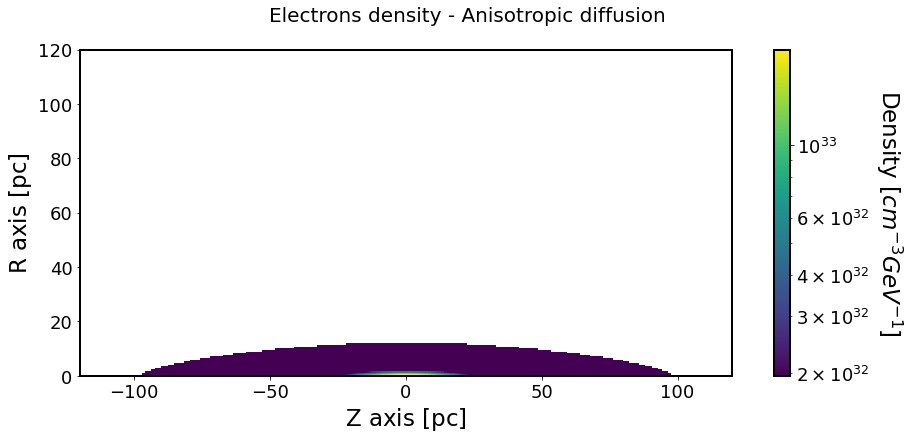

In [30]:
## Block to plot the contour plots for the same energy at different time steps and planes z, in the xy-plane ##

ien = 32             # chosen energy index
   
fig = plt.figure(figsize=(15,6))
fig.suptitle('Electrons density - Anisotropic diffusion', fontsize=20, y=0.98)
ax = plt.gca()

print('E =', E[ien], 'GeV')
print('')


extent = np.min(z)*L_ref, np.max(z)*L_ref, np.max(r)*L_ref, np.min(r)*L_ref
cp = plt.imshow(U_matrix[:, :, ien+1], animated=True, aspect='equal', cmap='viridis', extent = extent,
                interpolation='nearest',
                norm=matplotlib.colors.LogNorm(vmin=np.max(U_matrix[:-1, :-1, ien+1])/10, vmax=np.max(U_matrix[:-1, :-1, ien+1])) )

#extent = np.min(z)*L_ref, np.max(z)*L_ref, -np.max(r)*L_ref, 0
#cp = plt.imshow(U_matrix[:-1, 1:-1, ien+1], animated=True, aspect='equal', cmap='viridis', extent = extent,
#                interpolation='nearest',
#                norm=matplotlib.colors.LogNorm(vmin=np.max(U_matrix[::-1, :-1, ien+1])/1000, vmax=np.max(U_matrix[::-1, :-1, ien+1])) )

plt.xlim(left = -L_ref, right = L_ref)
plt.ylim(bottom = 0, top = L_ref)

plt.text(55, 100, 'E$_e$= ' + str(round(E[ien]*1e-3, 1)) + ' TeV', fontsize=19, c='white')
plt.text(65, 80, r'M$_A$= ' + str(round(M_A, 1)), fontsize=22, c='white', weight = 'bold')

cbar = fig.colorbar(cp)
cbar.ax.get_yaxis().labelpad = 35                       
cbar.ax.set_ylabel(r'Density [$cm^{-3}GeV^{-1}}$]', rotation=270, fontsize=23)
plt.xlabel(r'Z axis [$\mathrm{pc}$]', fontsize=23)
plt.ylabel(r'R axis [$\mathrm{pc}$]', fontsize=23)

#plt.savefig('C:/Users/pedro/OneDrive/Escritorio/TeV_electons-Map_{}TeV.png'.format(round(E[ien]*1e-3, 1)), dpi=250)
#plt.savefig('C:/Users/pedro/OneDrive/Escritorio/TeV_electons_CN-PR.pdf')

#ax.tick_params(axis='x', which='major', labelsize=22, pad=0)
#ax.tick_params(axis='y', which='major', labelsize=22, pad=0)
#ax.xaxis.labelpad = 16
#ax.yaxis.labelpad = 16
plt.show()